In [1]:
# imports
import os
import json
import argparse
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from scipy.optimize import linear_sum_assignment

In [2]:

# Paths/metadata (resolve relative to repo root)
FEATURES_DIR = '../data/features/gtzan'
MODEL_PATH = '../models/M4_82ta_0.68tl.keras'  # choose the model to test
META_PATH = f'{FEATURES_DIR}/metadata.json'

# load metadata
with open(META_PATH, "r") as f:
    metadata = json.load(f)

model = load_model(MODEL_PATH)
num_outputs = int(model.output_shape[-1])

classes_to_keep = sorted({m['genre'] for m in metadata})
print('genres:', classes_to_keep)

label_map = {g: i for i, g in enumerate(classes_to_keep)}
print('label_map:', label_map)
num_classes = len(classes_to_keep)
assert num_classes == num_outputs, f'classes ({num_classes}) != model outputs ({num_outputs})'


genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
label_map: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [3]:

# build file list for relative paths to the features files and labels for NumPy array
file_paths, labels = [], []
for m in metadata:
    if m.get('split') != 'test':
        continue
    if m['genre'] not in classes_to_keep:
        continue
    genre = m['genre']
    npz_name = m['filename'].replace('.wav', '.npz')
    p = os.path.join(FEATURES_DIR, m['split'], genre, npz_name)
    if os.path.exists(p):
        file_paths.append(p)
        labels.append(label_map[genre])
labels = np.array(labels, dtype=int)
print('test files', len(file_paths))


test files 2199


In [4]:

# use provided test split from preprocessing
test_paths = file_paths
y_test = labels


In [5]:

# Loader utilities and build X_test
# input shape 128, 216, 1 to match new preprocessing (5s windows, hop 512)
TARGET_SHAPE = (128, 216, 1)
# helper to make spectrogram exactly the target shape
def pad_or_crop_time(x, target_frames=216):
    if x.ndim == 2:
        x = x[..., np.newaxis]
    T = x.shape[1]
    if T == target_frames:
        return x
    # if too long center crop to target shape to keep content centered
    if T > target_frames:
        start = (T - target_frames) // 2
        return x[:, start:start+target_frames, :]
    # if too short, zero-pad on both sides
    pad_left = (target_frames - T) // 2
    pad_right = target_frames - T - pad_left
    return np.pad(x, ((0,0),(pad_left,pad_right),(0,0)), mode='constant')

# load_mel: opens each .npz, reads mel_spec, applies pad/crop, returns float
def load_mel(path):
    with np.load(path) as arr:
        x = arr['mel_spec']
    x = pad_or_crop_time(x, TARGET_SHAPE[1])
    return x.astype('float32')

# Builds the evaluation tensor
X_test = np.stack([load_mel(p) for p in test_paths], axis=0)
y_test = np.asarray(y_test, dtype=int)
print('X_test', X_test.shape, 'y_test', y_test.shape)
assert X_test.shape[1:] == TARGET_SHAPE, f'unexpected shape {X_test.shape[1:]}'


X_test (2199, 128, 216, 1) y_test (2199,)


In [6]:
# Load model and predict
model = load_model(MODEL_PATH)
# class probabilities for each test sample
probs = model.predict(X_test, verbose=0)
y_pred = probs.argmax(axis=1)
# get top 3 classes per sample and check if in top 3
top3 = np.argsort(probs, axis=1)[:, -3:]
top3_hit = np.array([y_test[i] in top3[i] for i in range(len(y_test))])

In [7]:
# Metrics
acc = accuracy_score(y_test, y_pred)
top3_acc = top3_hit.mean()
print(f'Accuracy: {acc:.4f}  |  Top-3: {top3_acc:.4f}')
print(classification_report(y_test, y_pred, target_names=classes_to_keep, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

Accuracy: 0.9100  |  Top-3: 0.9700
              precision    recall  f1-score   support

       blues     0.9650    0.8773    0.9190       220
   classical     0.9953    0.9727    0.9839       220
     country     0.8922    0.8311    0.8605       219
       disco     0.8621    0.9091    0.8850       220
      hiphop     0.9286    0.9455    0.9369       220
        jazz     0.9391    0.9818    0.9600       220
       metal     0.9502    0.9545    0.9524       220
         pop     0.8589    0.9409    0.8980       220
      reggae     0.9528    0.9182    0.9352       220
        rock     0.7682    0.7682    0.7682       220

    accuracy                         0.9100      2199
   macro avg     0.9112    0.9099    0.9099      2199
weighted avg     0.9113    0.9100    0.9099      2199



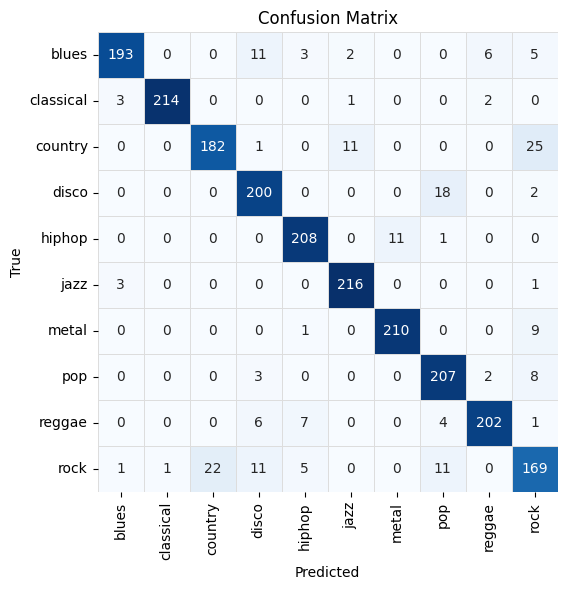

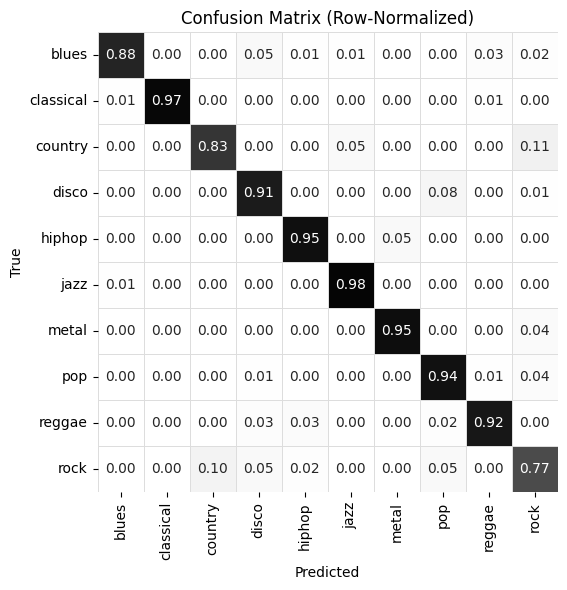

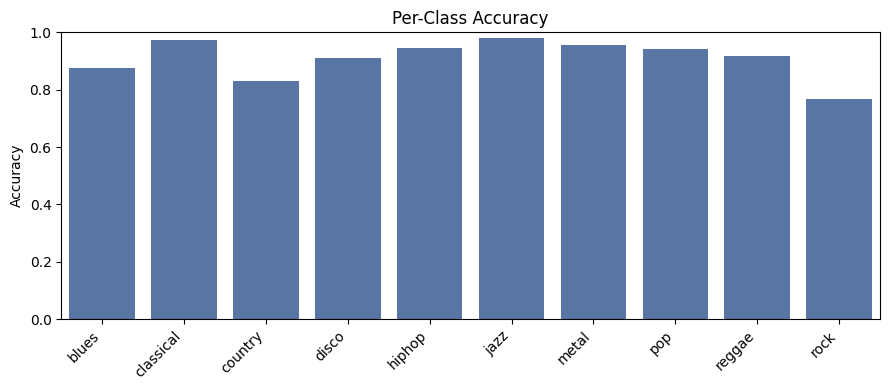

In [8]:
# Plots and save to docs/visuals directory
visuals_dir = 'docs/visuals'
os.makedirs(visuals_dir, exist_ok=True)

# Plot 1: Raw confusion Matrix
# each row sums to 20 (Jazz is being misclassified as country )
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_to_keep, yticklabels=classes_to_keep,
            linewidths=0.5, linecolor='#ddd', square=True,
            annot_kws={'fontsize':10})
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("docs/visuals/confusion_matrix.png", dpi=200, bbox_inches='tight')

# Plot 2: Normalzed confusion matrix 
# each row sums to 1 (darker = more accurate)
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greys', cbar=False,
            vmin=0, vmax=1,
            xticklabels=classes_to_keep, yticklabels=classes_to_keep,
            linewidths=0.5, linecolor='#ddd', square=True,
            annot_kws={'fontsize':10})
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Row-Normalized)')
plt.tight_layout() 
plt.savefig("docs/visuals/confusion_matrix_norm.png", dpi=200, bbox_inches='tight')
per_class_acc = np.diag(cm_norm)

# Plot 3: Per-class accuracy bar chart
plt.figure(figsize=(9,4))
sns.barplot(x=classes_to_keep, y=per_class_acc, color='#4C72B0')
plt.ylim(0,1); plt.ylabel('Accuracy'); plt.title('Per-Class Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.savefig("docs/visuals/per_class_accuracy.png", dpi=200, bbox_inches='tight')
